In [1]:
from func_def import *
df = pd.read_csv('data_features_ready.csv').dropna().reset_index(drop=True)
print(df.columns)
df.tail(3)

Index(['date', 'result', 'method', 'rounds', 'fighter', 'opponent',
       'fight_time', 'ground_str_lnd_mean_dif', 'ground_str_att_mean_dif',
       'sig_str%_mean_dif', 'total_str_lnd_mean_dif', 'ctrl_mean_dif'],
      dtype='object')


,date,result,method,rounds,fighter,opponent,fight_time,ground_str_lnd_mean_dif,ground_str_att_mean_dif,sig_str%_mean_dif,total_str_lnd_mean_dif,ctrl_mean_dif
5155,2000-09-22,L,Submission,3,Eugene Jackson,Jeremy Horn,20.53,-1.308676,-1.439807,-1.283755,0.114500,-0.190332
5156,2000-09-22,L,Submission,3,Laverne Clar,Fabiano Ih,5.17,0.769727,0.521913,-0.537933,2.560189,1.736084
5157,2000-06-09,L,Decision - Unanimous,5,Pedro Rizzo,Kevin Randleman,25.00,-1.012125,-3.001106,0.411294,-1.040021,-6.585429


In [2]:
# User defined parameters
y = 'result'
X = [col for col in df.columns if '_dif' in col]
#X = ['slpm_dif','sapm_dif','str_acc_dif','win_streak_dif']

DROP_OUTLIERS = False
VALIDATION_DATA = 0
TEST_DATA = 0.3

df = df[['date','fighter','opponent','method'] + X + [y]]
df = set_train_test(X_columns=X, y_columns=y, data=df, test_size=TEST_DATA, valid_size=VALIDATION_DATA)
df.head(5)

Data split: Data=(5158, 11), train_set=(3602, 11), validation_set=(0, 11), test_set=(1556, 11)


,set,date,fighter,opponent,method,ground_str_lnd_mean_dif,ground_str_att_mean_dif,sig_str%_mean_dif,total_str_lnd_mean_dif,ctrl_mean_dif,result
0,test,2023-11-04,Jailton Almeida,Derrick Lewis,Decision - Unanimous,1.687381,1.650138,0.885908,0.420246,1.300481,W
1,train,2023-11-04,Don'Tale Mayes,Rodrigo Nascimento,Decision - Unanimous,0.079896,0.163596,0.004482,0.289602,0.173922,L
2,test,2023-11-04,Caio Borralho,Abus Magomedo,Decision - Unanimous,1.119734,0.822658,-1.012547,0.766902,2.599778,W
3,test,2023-11-04,Vitor Petrin,Modestas Bukauskas,KO/TKO,1.766291,1.409541,0.682502,0.760084,2.648596,W
4,train,2023-11-04,Angela Hill,Denise Gomes,Decision - Unanimous,-1.189037,-1.024778,-1.215953,1.036918,-0.505768,W


In [3]:
# Remove outliers
df['outlier'] = False

for feature in X:
    try:
        pd.to_numeric(df[feature])
        mean = np.mean(df[feature])
        std = np.std(df[feature])
        df.loc[(df[feature] > mean + 3*std)|(df[feature] < mean - 3*std),'outlier'] = True
    except:
        continue

print(f'1d Outliers Detected: {df.outlier.value_counts().to_dict()}')    

if DROP_OUTLIERS:
    df = df[df.outlier == False].reset_index(drop=True)

1d Outliers Detected: {False: 4913, True: 245}


In [4]:
print('Pre-Training Report:\n---------------------')
print(f"Train records: {len(df[df.set=='train'])}")
print('Train records of df.result==%s : %d' %(df.result.unique()[0],len(df[(df.result == df.result.unique()[0])&(df.set == 'train')])))
print('Train records of df.result==%s : %d' %(df.result.unique()[1],len(df[(df.result == df.result.unique()[1])&(df.set == 'train')])))
print('-----------------------------------')
print('Validation records: %d' %len(df[df.set=='validation']))
print('Validation records of df.result==%s : %d' %(df.result.unique()[0],len(df[(df.result == df.result.unique()[0])&(df.set == 'validation')])))
print('Validation records of df.result==%s : %d' %(df.result.unique()[1],len(df[(df.result == df.result.unique()[1])&(df.set == 'validation')])))
print('-----------------------------------')
print('Test records: %d' %len(df[df.set=='test']))
print('Test records of df.result==%s : %d' %(df.result.unique()[0],len(df[(df.result == df.result.unique()[0])&(df.set == 'test')])))
print('Test records of df.result==%s : %d' %(df.result.unique()[1],len(df[(df.result == df.result.unique()[1])&(df.set == 'test')])))


Pre-Training Report:
---------------------
Train records: 3602
Train records of df.result==W : 1763
Train records of df.result==L : 1839
-----------------------------------
Validation records: 0
Validation records of df.result==W : 0
Validation records of df.result==L : 0
-----------------------------------
Test records: 1556
Test records of df.result==W : 786
Test records of df.result==L : 770


In [5]:
# Train classifiers
df['result'] = [1 if item=='W' else 0 for item in df.result]
X_train = df[df['set'] == 'train'][X]
y_train = np.ravel(np.array(df[df['set'] == 'train'][y]).reshape(-1,1))

MODELS = {'xgb':XGBClassifier(),'lg':LogisticRegression(),
          'knn':KNeighborsClassifier(),'nb':GaussianNB(),
          'dt':DecisionTreeClassifier(),'rf':RandomForestClassifier(),
          'nn':MLPClassifier()}

for model in tqdm(MODELS.values()):
    model.fit(X=X_train,y=y_train)

print(f'{list(MODELS.values())}')

100%|██████████| 7/7 [00:02<00:00,  2.87it/s]

[XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...), LogisticRegression(), KNeighborsClassifier(), GaussianNB(), DecisionTreeClassifier(), RandomForestClassifier(), MLPClassifier()]


In [6]:
# Evaluate performance
X_test = df[df['set'] == 'test'][X]
y_test = df[df['set']=='test'][y]

for name,model in zip(MODELS.keys(),MODELS.values()):
    df[f'{name}_{y}_pred'] = model.predict(df[X])
    df[f'{name}_{y}_proba'] = [max(item) for item in model.predict_proba(df[X])]

df['vote_result'] = np.round(df[[col for col in df.columns if f'{y}_pred' in col]].sum(axis=1)/len(MODELS),0) # result after voting between all models
df['vote_result_proba'] = df[[col for col in df.columns if f'{y}_proba' in col]].mean(axis=1) # mean probability between all models
df.head()    

,set,date,fighter,opponent,method,ground_str_lnd_mean_dif,ground_str_att_mean_dif,sig_str%_mean_dif,total_str_lnd_mean_dif,ctrl_mean_dif,result,outlier,xgb_result_pred,xgb_result_proba,lg_result_pred,lg_result_proba,knn_result_pred,knn_result_proba,nb_result_pred,nb_result_proba,dt_result_pred,dt_result_proba,rf_result_pred,rf_result_proba,nn_result_pred,nn_result_proba,vote_result,vote_result_proba
0,test,2023-11-04,Jailton Almeida,Derrick Lewis,Decision - Unanimous,1.687381,1.650138,0.885908,0.420246,1.300481,1,False,1,0.630386,1,0.597687,1,0.6,1,0.697433,1,1.0,1,0.77,0,0.514188,1.0,0.687099
1,train,2023-11-04,Don'Tale Mayes,Rodrigo Nascimento,Decision - Unanimous,0.079896,0.163596,0.004482,0.289602,0.173922,0,False,0,0.681177,1,0.501674,1,0.8,1,0.550269,0,1.0,0,0.71,0,0.508401,0.0,0.678789
2,test,2023-11-04,Caio Borralho,Abus Magomedo,Decision - Unanimous,1.119734,0.822658,-1.012547,0.766902,2.599778,1,False,1,0.581593,1,0.536691,1,0.8,1,0.693869,0,1.0,1,0.62,1,0.591578,1.0,0.689104
3,test,2023-11-04,Vitor Petrin,Modestas Bukauskas,KO/TKO,1.766291,1.409541,0.682502,0.760084,2.648596,1,False,1,0.948881,1,0.597291,1,0.6,1,0.752482,0,1.0,1,0.65,1,0.581242,1.0,0.732842
4,train,2023-11-04,Angela Hill,Denise Gomes,Decision - Unanimous,-1.189037,-1.024778,-1.215953,1.036918,-0.505768,1,False,1,0.680277,0,0.582355,1,0.6,0,0.673227,1,1.0,1,0.80,0,0.581957,1.0,0.702545


Model Performance("W" = Positive; "L" = Negative):
    Accuracy [(tp + fn)/(tp + fp + tn + fn)]= 0.8770127706829539
    Precision [(tp)/(tp + fp)] = 0.914572864321608
    Recall [tp/(tp + fn)] = 0.8258650028360749
    F1 score [precision*recall/(precision + recall)] = 0.43397913561847984


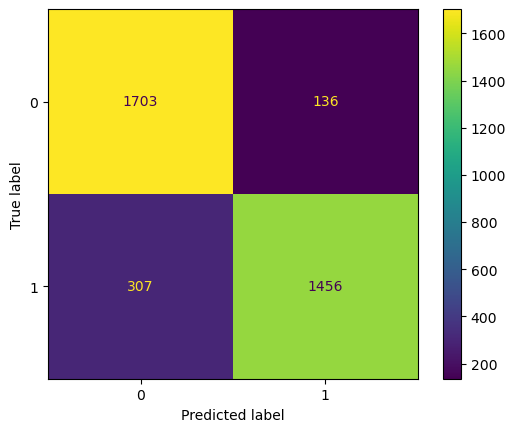

In [7]:
# Voting results
DATA_SET = 'train'

d = df[df.set==DATA_SET]
TP = len(d[(d[y] == d['vote_result'])&(d['vote_result'] == 1)])
FP = len(d[(d[y] != d['vote_result'])&(d['vote_result'] == 1)])
TN = len(d[(d[y] == d['vote_result'])&(d['vote_result'] == 0)])
FN = len(d[(d[y] != d['vote_result'])&(d['vote_result'] == 0)])

precision = TP/(TP+FP)
recall = TP/(TP+FN)
cm = confusion_matrix(y_true=d[y],y_pred=d['vote_result'])

print('Model Performance("W" = Positive; "L" = Negative):')
print(f'    Accuracy [(tp + fn)/(tp + fp + tn + fn)]= {(TP + TN)/len(d)}')
print(f'    Precision [(tp)/(tp + fp)] = {precision}')
print(f'    Recall [tp/(tp + fn)] = {recall}')
print(f'    F1 score [precision*recall/(precision + recall)] = {(precision*recall)/(precision+recall)}')
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_).plot()

Model Performance("W" = Positive; "L" = Negative):
    Accuracy [(tp + fn)/(tp + fp + tn + fn)]= 0.5359897172236504
    Precision [(tp)/(tp + fp)] = 0.5481927710843374
    Recall [tp/(tp + fn)] = 0.4631043256997455
    F1 score [precision*recall/(precision + recall)] = 0.2510344827586207


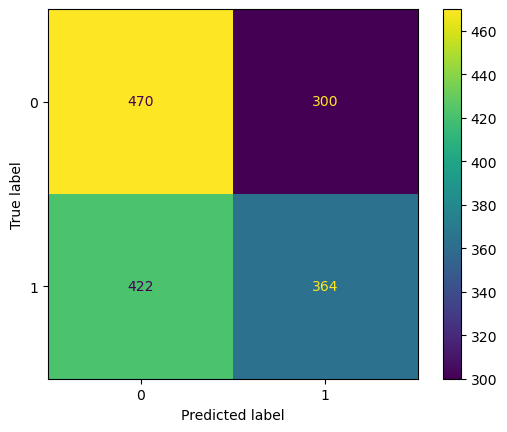

In [8]:
# Voting results with chosen high probability fights
DATA_SET = 'test'

d = df[df.set==DATA_SET]
TP = len(d[(d[y] == d['vote_result'])&(d['vote_result'] == 1)])
FP = len(d[(d[y] != d['vote_result'])&(d['vote_result'] == 1)])
TN = len(d[(d[y] == d['vote_result'])&(d['vote_result'] == 0)])
FN = len(d[(d[y] != d['vote_result'])&(d['vote_result'] == 0)])

precision = TP/(TP+FP)
recall = TP/(TP+FN)
cm = confusion_matrix(y_true=d[y],y_pred=d['vote_result'])

print('Model Performance("W" = Positive; "L" = Negative):')
print(f'    Accuracy [(tp + fn)/(tp + fp + tn + fn)]= {(TP + TN)/len(d)}')
print(f'    Precision [(tp)/(tp + fp)] = {precision}')
print(f'    Recall [tp/(tp + fn)] = {recall}')
print(f'    F1 score [precision*recall/(precision + recall)] = {(precision*recall)/(precision+recall)}')
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_).plot()

Model Performance("W" = Positive; "L" = Negative):
    Accuracy [(tp + fn)/(tp + fp + tn + fn)]= 0.5791245791245792
    Precision [(tp)/(tp + fp)] = 0.5853658536585366
    Recall [tp/(tp + fn)] = 0.4931506849315068
    F1 score [precision*recall/(precision + recall)] = 0.26765799256505574


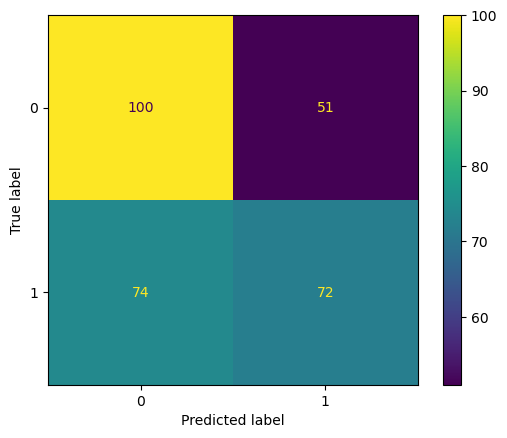

In [9]:
# Voting results with chosen high probability fights
DATA_SET = 'test'
MIN_PROBABILITY = 0.7

d = df[(df.set==DATA_SET)&(df.vote_result_proba > MIN_PROBABILITY)]
TP = len(d[(d[y] == d['vote_result'])&(d['vote_result'] == 1)])
FP = len(d[(d[y] != d['vote_result'])&(d['vote_result'] == 1)])
TN = len(d[(d[y] == d['vote_result'])&(d['vote_result'] == 0)])
FN = len(d[(d[y] != d['vote_result'])&(d['vote_result'] == 0)])

precision = TP/(TP+FP)
recall = TP/(TP+FN)
cm = confusion_matrix(y_true=d[y],y_pred=d['vote_result'])

print('Model Performance("W" = Positive; "L" = Negative):')
print(f'    Accuracy [(tp + fn)/(tp + fp + tn + fn)]= {(TP + TN)/len(d)}')
print(f'    Precision [(tp)/(tp + fp)] = {precision}')
print(f'    Recall [tp/(tp + fn)] = {recall}')
print(f'    F1 score [precision*recall/(precision + recall)] = {(precision*recall)/(precision+recall)}')
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_).plot()